Note: This assumes that the `mantidimaging` is available on the PATH, otherwise the subprocess commands will not be able to execute the package successfully. On how to do that please set up global access to the package https://mantidproject.github.io/mantidimaging/user_guide/setting_up.html

In [60]:
# Setup the package, this is done automatically with the startup scripts
import os
import sys

# Setup some constants
HOME = os.path.expanduser('~')
CHADWICK_PATH = os.path.join(HOME, 'mantidimaging', 'notebooks', 'demoimages')
CHADWICK_SAMPLE_PATH = os.path.join(CHADWICK_PATH, 'sample')
SINOGRAMS_PATH = os.path.join(CHADWICK_PATH, 'sinograms')
SINOGRAMS_MLOG_PATH = os.path.join(CHADWICK_PATH, 'sinograms_mlog')

CHADWICK_PREPROC_PATH = os.path.join(CHADWICK_PATH, 'preproc')
CHADWICK_PREPROC_MLOG_PATH = os.path.join(CHADWICK_PATH, 'preproc-mlog')

MANUAL_COR_OUTPUT_PATH = os.path.join(CHADWICK_PATH, 'cors')

RECONSTRUCTION_OUTPUT_PATH = os.path.join(CHADWICK_PATH, 'reconstructed')
RECONSTRUCTION_MLOG_OUTPUT_PATH = os.path.join(CHADWICK_PATH, 'reconstructed_mlog')

MANTIDIMAGING_PATH = os.path.join(HOME, 'mantidimaging')
print(HOME, CHADWICK_PATH, MANTIDIMAGING_PATH)
sys.path[0]=MANTIDIMAGING_PATH

import mantidimaging
print(mantidimaging.__package__)

# Setup matplotlib to use the notebook backend
import matplotlib
matplotlib.use('nbagg')
from matplotlib import pyplot

# Create matplotlib objects
def show(image, idx=0):
    fig, img_axes = pyplot.subplots(nrows=1,ncols=1)
    
    image_obj = img_axes.imshow(image.get_sample()[idx], cmap='Greys_r')

    pyplot.show()

# import package from isis_imaging's GUI part
from mantidimaging.gui.stack_visualiser import sv_histogram

# python abuse to plot the histograms on the same plot, it works by default in the package

def plot_histograms_magically(data, idx1=0, idx2=None):
    # save the original function reference
    if idx2:
        temp_func_storage = sv_histogram._show
        def _temporary_empty_function(): pass
        # set to a function that does nothing
        sv_histogram.show_transparent(data.get_sample()[idx2].flatten(), "Normal Contrast", "")

        # restore so that the plot is shown next time
        sv_histogram._show = temp_func_storage

    sv_histogram.show_transparent(data.get_sample()[idx1].flatten(), "Low Contrast", "Magic")    

/home/dtasev /home/dtasev/mantidimaging/notebooks/demoimages /home/dtasev/mantidimaging
mantidimaging


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
# Load some data in

<IPython.core.display.Javascript object>


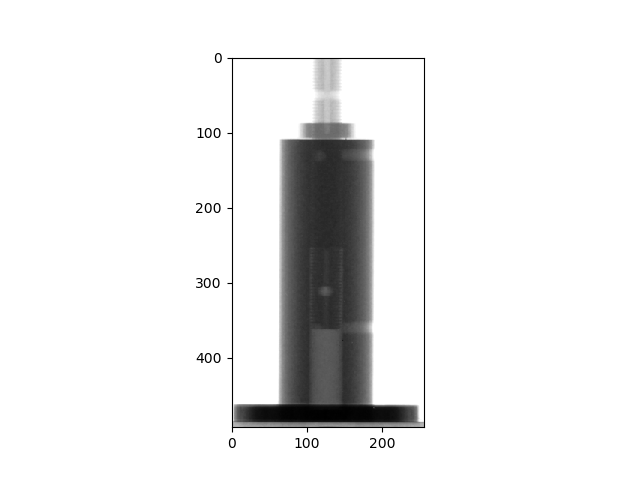

In [5]:
# Load some data in, format for indices is [start, end, step]
indices = [0, 2, 1]

# use the package directly in a script/ipython/notebook style
images = mantidimaging.core.io.loader.load(CHADWICK_PREPROC_PATH, indices=indices)
show(images)

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
# Finding the COR

In [20]:
# only run on 2 images
import subprocess

# Another interface to the package: the CLI, used on SCARF
# does a command line call, exactly as if I typed it in the terminal. 

print("Command line executed:\n", 
      " ".join(['mantidimaging', '-i', CHADWICK_PREPROC_PATH, '--indices', '0', '2', '1', '--imopr', 'cor']),
     "\n")

# This is the interface that will be used in the Reconstruction part
result = subprocess.run(['mantidimaging', '-i', CHADWICK_PREPROC_PATH, \
                         '--indices', '0', '2', '1', \
                         '--imopr', 'cor'], stdout=subprocess.PIPE)

if result.stdout:
    print(result.stdout.decode())
if result.stderr:
    print(result.stderr.decode())

Command line executed:
 mantidimaging -i /home/dtasev/mantidimaging/notebooks/demoimages/preproc --indices 0 2 1 --imopr cor 

Found anaconda at /home/dtasev/anaconda2/bin
 >> WARNING: No output path specified, no output will be produced!
Sample: [========================================]2 / 2
Data shape (2, 493, 257)
*********************************************
*
*     Running IMOPR with action COR. This works ONLY with sinograms
*
*********************************************
 ---Importing tool tomopy
 ---Tool loaded. Elapsed time: 3.09944152832e-05 sec.
Calculating projection angles..
Running COR for index 0 [ 159.2]
Running COR for index 1 [ 159.2]
Total execution time was 1.17988300323 sec



The calculated center of rotation can be found with the prefix 

```
Running COR for index * [ ...]`
```

A thing to note here is the message 

```text
This works ONLY with sinograms
```

because what we're running the algorithm with is the _projections_. There is no way to automatically determine if we have a projection or a sinogram, as the dimensons vary depending on crop.

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>

# Converting to Sinograms

<br>
## Sinogram - a row from each image, shows the movement of the row throughout the images
<br>

### This means that for sinograms you need _ALL_ of the information along the Z axis

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
# Visualise a projection

<IPython.core.display.Javascript object>


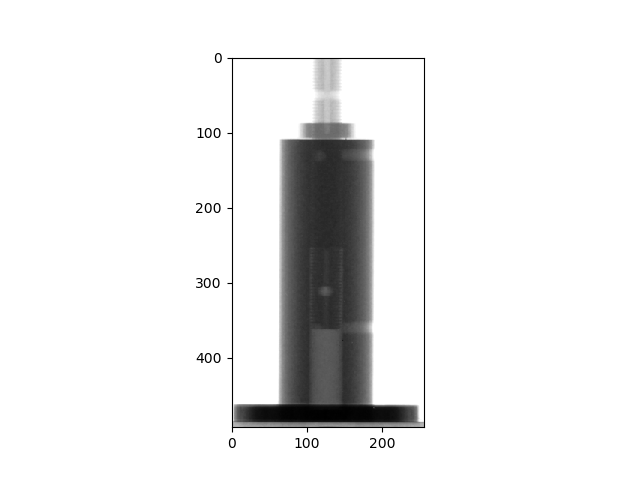

In [21]:
# show one of the first projections
show(images) 

# How does a sinogram look?

<IPython.core.display.Javascript object>


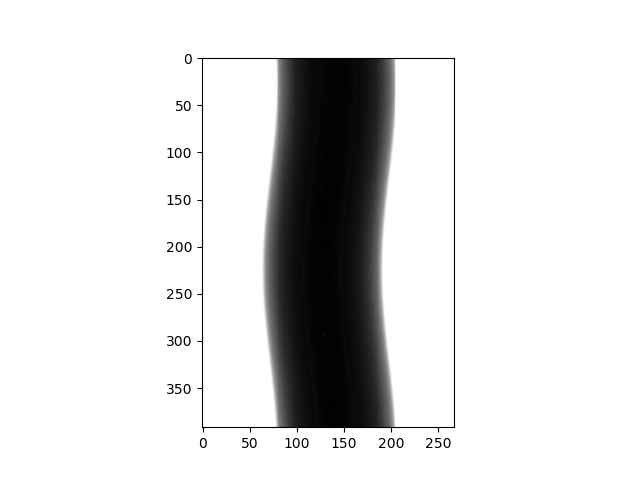

In [29]:
sinogram_indices = [0, 2, 1]
sinograms = mantidimaging.core.io.loader.load(SINOGRAMS_PATH, indices=sinogram_indices)

# shows the 600th sinogram. This is the 600th row of EVERY projection 
# from the image volume and shows the movement of the object through the volume
show(sinograms) 

The following would be the code to convert the projections to sinograms, however that requires loading the whole dataset, but not all images are provided for the demo.

```python

import subprocess
result = subprocess.run(['mantidimaging', '-i', CHADWICK_SAMPLE_PATH, \
                        '-o', SINOGRAMS_PATH, '--convert', '--swap-axes'], stdout=subprocess.PIPE)
print(result.stdout.decode())
```

In [25]:
print("The command line to convert the projections to sinograms is:\n", " ".join(['mantidimaging', '-i', CHADWICK_SAMPLE_PATH, '-o', SINOGRAMS_PATH, '--convert', '--swap-axes']))

The command line to convert the projections to sinograms is:
 mantidimaging -i /home/dtasev/mantidimaging/notebooks/demoimages/sample -o /home/dtasev/mantidimaging/notebooks/demoimages/sinograms --convert --swap-axes


<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
# Why do we work with Sinograms and not the original slices?
Tomopy will implicitly convert the data to sinograms, if we send projections. This doubles the memory usage (and loses time converting the data). If we pass sinograms, we don't have surprise memory doubling.

It is specified through a `sinogram_order=True` flag in the actual Tomopy call:
```python
    recon = self._tomopy.recon(
        tomo=sample,
        theta=proj_angles,
        center=cors,
        ncore=cores,
        algorithm=alg,
        sinogram_order=True,
        **kwargs)
```

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
# How to use automatic approximation of COR

In [30]:
print("Command line:\n", " ".join(['mantidimaging', '-i', SINOGRAMS_PATH, \
                         '--indices', '550', '600', '500', \
                         '--imopr', 'cor']))

import subprocess
result = subprocess.run(['mantidimaging', '-i', SINOGRAMS_PATH, \
                         '--indices', '0', '2', '1', \
                         '--imopr', 'cor'], stdout=subprocess.PIPE)
if result.stdout:
    print(result.stdout.decode())
if result.stderr:
    print(result.stderr.decode())

Command line:
 mantidimaging -i /home/dtasev/mantidimaging/notebooks/demoimages/sinograms --indices 550 600 500 --imopr cor
Found anaconda at /home/dtasev/anaconda2/bin
 >> WARNING: No output path specified, no output will be produced!
Sample: [========================================]1 / 1
Data shape (1, 392, 267)
*********************************************
*
*     Running IMOPR with action COR. This works ONLY with sinograms
*
*********************************************
 ---Importing tool tomopy
 ---Tool loaded. Elapsed time: 2.98023223877e-05 sec.
Calculating projection angles..
Running COR for index 0 [ 139.234375]
Total execution time was 0.420841932297 sec



The center of rotation is a lot closer to the actual one when run on the sinogram (the one I found and which we will use below is 134).

The algorithm is generally fairly innacurate for the high noise datasets from neutron tomography.

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
# How to use manual finding of COR

The centers of rotations we are reconstructing are specified after the `--imopr` flag.

We will reconstruct the CORs starting 130 to 140, with a step of 1. The output will be saved out in the specified directory with `-o`.

In [35]:
import subprocess
result = subprocess.run(['mantidimaging', '-i', SINOGRAMS_PATH, \
                         '-o', MANUAL_COR_OUTPUT_PATH, \
                         '--indices', '0', '2', '1', \
                         '--imopr', '130', '140', '1', 'corwrite'], stdout=subprocess.PIPE)

if result.stdout:
    print(result.stdout.decode())
if result.stderr:
    print(result.stderr.decode())

Found anaconda at /home/dtasev/anaconda2/bin
Sample: [========================================]1 / 1
Data shape (1, 392, 267)
*********************************************
*
*     Running IMOPR with action COR using tomopy write_center. This works ONLY with sinograms!
*
*********************************************
 ---Importing tool tomopy
 ---Tool loaded. Elapsed time: 3.40938568115e-05 sec.
Calculating projection angles..
[130, 140, 1]
Starting writing CORs for slice 0 in /home/dtasev/mantidimaging/notebooks/demoimages/cors/0
Finished writing CORs in /home/dtasev/mantidimaging/notebooks/demoimages/cors
Total execution time was 0.395020008087 sec



<IPython.core.display.Javascript object>


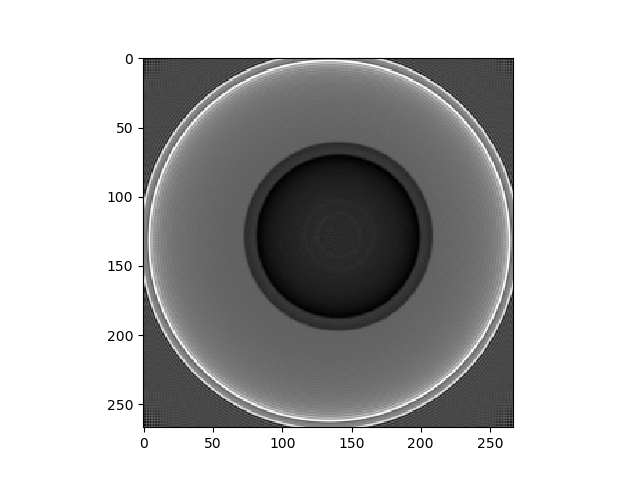

In [40]:
recon_slices = mantidimaging.core.io.loader.load(os.path.join(MANUAL_COR_OUTPUT_PATH, '0'), in_format='tiff')

# There is not much difference between going below or over the COR
show(recon_slices, 0) # too low COR

<IPython.core.display.Javascript object>


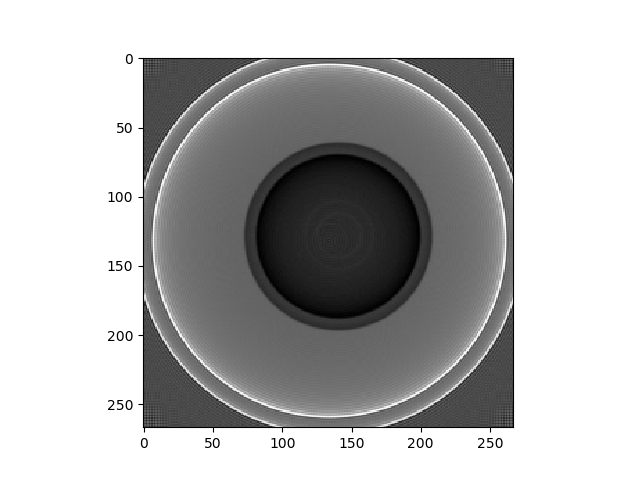

In [41]:
# too high COR
show(recon_slices, 9)

<IPython.core.display.Javascript object>


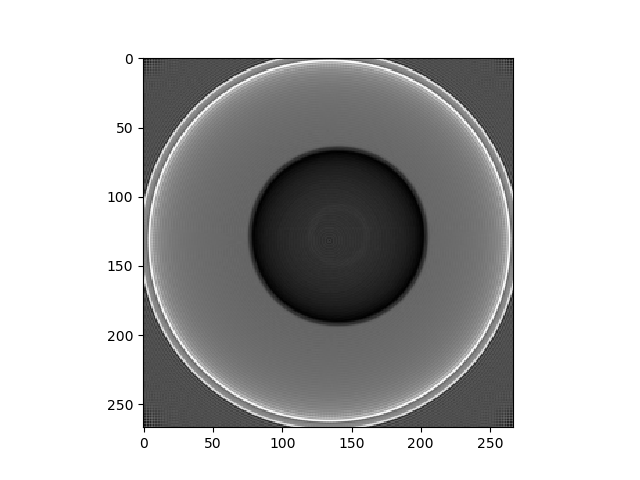

In [42]:
# Closer to the correct COR, but still a little bit of shadow left
show(recon_slices, 6)

<IPython.core.display.Javascript object>


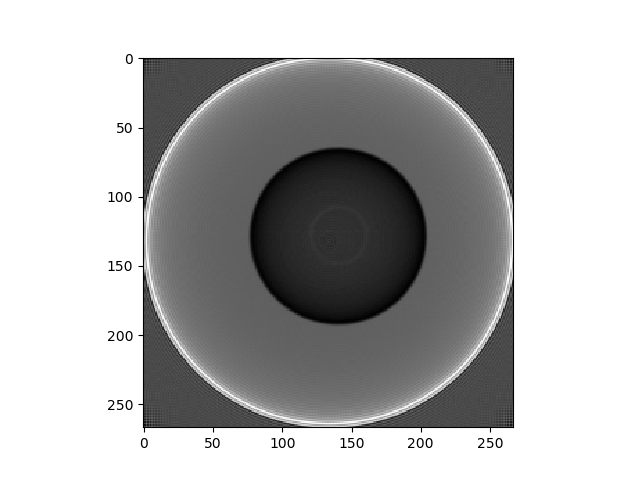

In [43]:
# just right
show(recon_slices, 4)

<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
# Running a reconstruction
## Setting up the reconstruction parameters

In [45]:
# Correct Reconstruction COR parameters
SLICE_CORS = [
  # Slice ID, Center of Rotation
    ('422',       '542'), 
    ('822',       '540'), 
    ('1222',      '540'), 
    ('1622',      '537'), 
    ('1822',      '536')
]

# Python 3 needs the list(...) as a gentle nudge, because zip is a generator
SLICE_IDS, CORS = list(zip(*SLICE_CORS))
print("Slices", SLICE_IDS)
print("Centers of Rotation", CORS)

Slices ('422', '822', '1222', '1622', '1822')
Centers of Rotation ('542', '540', '540', '537', '536')


## Trying to run a reconstruction

In [46]:
# Keep the same Centers of Rotation
# But add one more to the slice indices
# Now we have a slice that doesn't have a COR associated with it
WRONG_SLICE_IDS = (*SLICE_IDS, '1922',)
print(WRONG_SLICE_IDS)


# This will crash because we have not provided the same amount of CORs and slice IDs

import subprocess
result = subprocess.run(['mantidimaging', '-i', SINOGRAMS_PATH, \
                         '-o', RECONSTRUCTION_OUTPUT_PATH, \
                         '--reconstruction', \
                         '--cors', *CORS, \
                         '--cor-slices', *WRONG_SLICE_IDS, \
                         '-t', 'tomopy', \
                         '-a', 'gridrec'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
print(result.stderr.decode())

('422', '822', '1222', '1622', '1822', '1922')
Python 2.7.13 :: Anaconda custom (64-bit)
Traceback (most recent call last):
  File "/home/dtasev/mantidimaging/mantidimaging/main.py", line 68, in <module>
    main()
  File "/home/dtasev/mantidimaging/mantidimaging/main.py", line 23, in main
    config = recon_config.grab_full_config()
  File "/home/dtasev/mantidimaging/mantidimaging/core/configs/recon_config.py", line 41, in grab_full_config
    return ReconstructionConfig(functional_args, args)
  File "/home/dtasev/mantidimaging/mantidimaging/core/configs/recon_config.py", line 66, in __init__
    self.handle_special_arguments()
  File "/home/dtasev/mantidimaging/mantidimaging/core/configs/recon_config.py", line 117, in handle_special_arguments
    len_cor_slices))
ValueError: Centers of Rotation (len 5) doesn't match length of Slice Indices (len 6)!



<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
## Actually running the reconstruction
## Note: For visual comparison this data DOES NOT have Minus Log applied to it!

In [62]:
SLICE_CORS = [
  # Slice ID, Center of Rotation
    ('0',       '134'), 
    ('1',       '134')
]

SLICE_IDS, CORS = list(zip(*SLICE_CORS))
import subprocess
result = subprocess.run(['mantidimaging', '-i', SINOGRAMS_PATH, \
                         '-o', RECONSTRUCTION_OUTPUT_PATH, \
                         '--reconstruction', \
                         '--cors', *CORS, \
                         '--cor-slices', *SLICE_IDS, '-w'], stdout=subprocess.PIPE)
if result.stdout:
    print(result.stdout.decode())
if result.stderr:
    print(result.stderr.decode())

Found anaconda at /home/dtasev/anaconda2/bin
 > Note: Progress bar library TQDM not available. To install locally please use pip install tqdm. Falling back to ASCII progress bar.
 > Note: Running process on 8 cores.
 ---Importing tool tomopy Memory usage before execution:  142636 KB, 139.29296875 MB
 ---Tool loaded. Elapsed time: 8.51154327393e-05 sec. Memory usage after execution:  142636 KB, 139.29296875 MB. Memory change: 0.0 MB
Sample: [========================================]1 / 1
 > Note: Predicted memory usage for data: 0.399261474609 MB
Sample: [========================================]1 / 1
 > Note: Running the default filtering.
 ---Starting non-iterative reconstruction algorithm with TomoPy. Mean COR: 134.0, Number of CORs provided 1, Algorithm: gridrec... Memory usage before execution:  144800 KB, 141.40625 MB
 ---Reconstructed 3D volume. Shape: (1, 267, 267), and pixel data type: float32. Elapsed time: 0.116395950317 sec. Memory usage after execution:  147556 KB, 144.0976

In [50]:
path = os.path.join(RECONSTRUCTION_OUTPUT_PATH, 'reconstructed')

root, dirs, files = next(os.walk(path))
print("\n".join(sorted(files)))

recon_slice_000000.tif


<IPython.core.display.Javascript object>


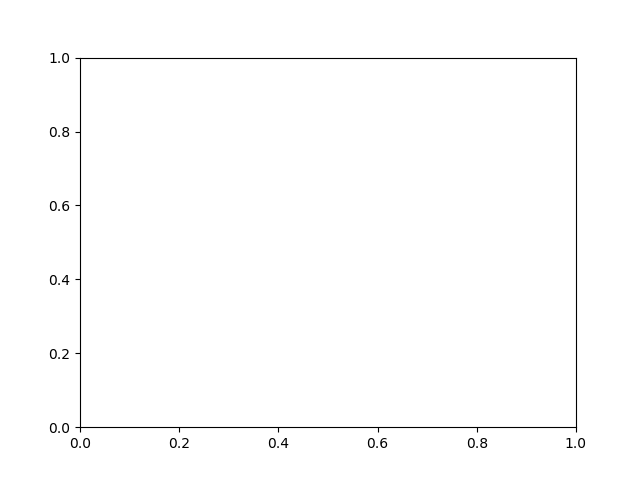

<IPython.core.display.Javascript object>


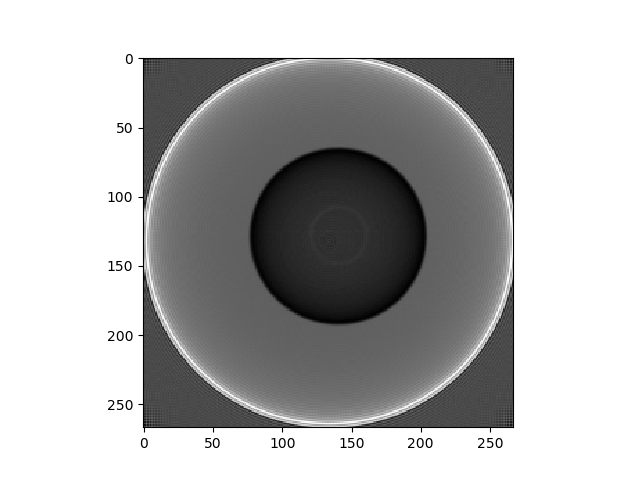

In [54]:
recon = mantidimaging.core.io.loader.load(path, indices=[0, 2, 1])

show(recon)

# Minus Log reconstruction

In [65]:
SLICE_CORS = [
  # Slice ID, Center of Rotation
    ('0',       '134'), 
    ('1',       '134')
]

SLICE_IDS, CORS = list(zip(*SLICE_CORS))
import subprocess
result = subprocess.run(['mantidimaging', '-i', SINOGRAMS_MLOG_PATH, \
                         '-o', RECONSTRUCTION_MLOG_OUTPUT_PATH, \
                         '--reconstruction', \
                         '--cors', *CORS, \
                         '--cor-slices', *SLICE_IDS, '-w'], stdout=subprocess.PIPE)
if result.stdout:
    print(result.stdout.decode())
if result.stderr:
    print(result.stderr.decode())

Found anaconda at /home/dtasev/anaconda2/bin
 > Note: Progress bar library TQDM not available. To install locally please use pip install tqdm. Falling back to ASCII progress bar.
 > Note: Running process on 8 cores.
 ---Importing tool tomopy Memory usage before execution:  143032 KB, 139.6796875 MB
 ---Tool loaded. Elapsed time: 9.29832458496e-05 sec. Memory usage after execution:  143032 KB, 139.6796875 MB. Memory change: 0.0 MB



<IPython.core.display.Javascript object>


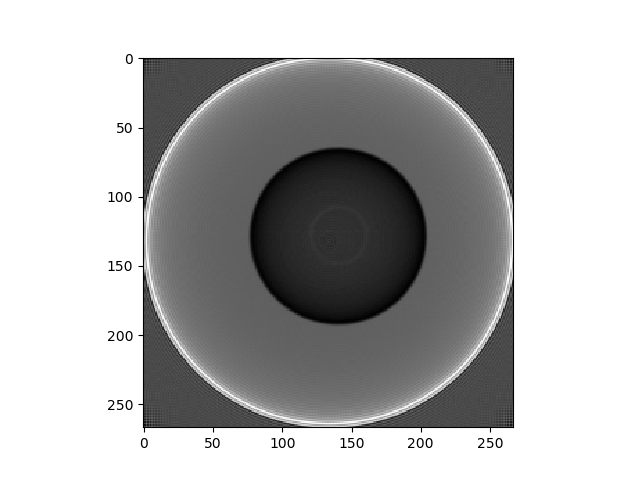

In [58]:
mlog_path = os.path.join(RECONSTRUCTION_MLOG_OUTPUT_PATH, 'reconstructed')
recon = mantidimaging.core.io.loader.load(mlog_path, indices=[0, 2, 1])

show(recon)